# HGCAL FE studies

### imports and initial setup

In [32]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from descartes import PolygonPatch
from tqdm import tqdm_notebook

from skhep.modeling import bayesian_blocks
import scripts.helpers as hlp
import scripts.readout_algorithms as algos

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

/home/naodell/work/hgcal


### get the data mixtures

In the script `**.py`, I make mixtures of signal and pileup samples.  

In [33]:
gen_list = []
df_list = []
inputdir = 'data/mc_mixtures/single_electron_pt35_skim'
for filename in os.listdir(inputdir):
    data_file = open(f'{inputdir}/{filename}', 'rb')
    gen_list.extend(pickle.load(data_file))
    df_list.extend(pickle.load(data_file))
    data_file.close()

algos = [
         'baseline',
         #'threshold_1bx_esort',  'threshold_8bx_esort',
         #'threshold_1bx_nosort', 'threshold_8bx_nosort', 
        ]
mippt_scan = np.arange(1, 10, 1.)
ratios = {n:{mippt:[] for mippt in mippt_scan} for n in algos}
columns = ['reco_e', 'sim_e', 'pt']
cell_labels = ['zside', 'layer', 'sector', 'panel']
data_iter = list(zip(gen_list, df_list))
for gpart, data in tqdm_notebook(data_iter, total=len(data_iter)):
    gen1 = gpart.iloc[0]
    gen2 = gpart.iloc[1]
    denom = np.array([gen1.e, gen1.e, gen1.pt])
    
    for mippt in mippt_scan:
        df = data.query(f'mip_pt > {mippt}')
        
        # carry out baseline selection
        df_baseline = df.query('sim_e > 0').groupby('zside')[columns].sum() 
        r = df_baseline/denom
        ratios['baseline'][mippt].append(r.values)

        # assess readout resolution and efficiency for various algorithms
        for k, v in ratios.items(): 
            if k == 'baseline':
                continue
            df_num = df.query(f'sim_e > 0 and {k}').groupby('zside')[columns].sum() 
            r = df_num/den
            v[mippt].append(r) 

            #print('*------------------------------------------*')
            #print(gen)
            #print(df_num)
            #print(df_den)
            #print(r)
            #print('*------------------------------------------*')
ratios = {a:{pt:np.vstack(d) for pt, d in algo_data.items()} for a, algo_data in ratios.items()}

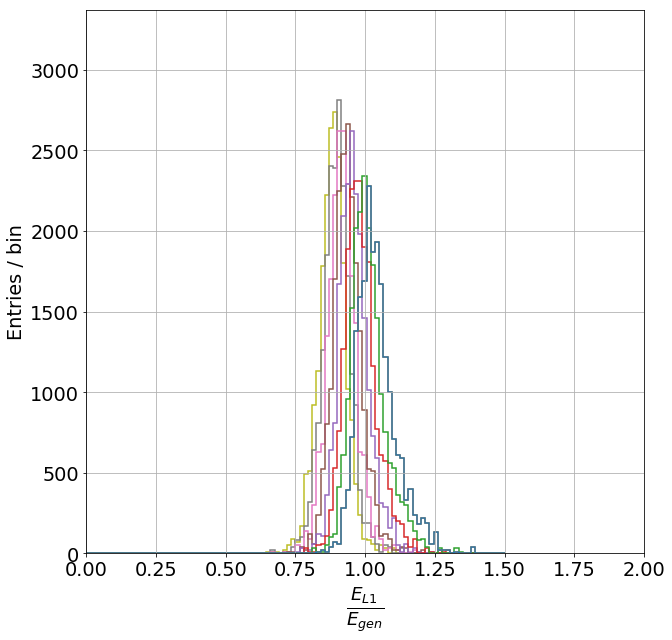

In [35]:
fig = plt.figure(figsize=(10, 10), facecolor='white')

ax = plt.subplot()
h, b, _ = ax.hist([ratios['baseline'][pt][:,0] for pt in mippt_scan], bins=100, range=[0, 1.5], linewidth=1.5, histtype='step')

ax.set_xlim(0, 2.)
ax.set_ylim(0, 1.2*np.max(h))
#ax.set_xlabel(r'$\frac{p_{T,L1}}{p_{T,gen}}$', fontsize=26)
ax.set_xlabel(r'$\frac{E_{L1}}{E_{gen}}$', fontsize=26)
ax.set_ylabel('Entries / bin')

#labels = ['8 bx', '1 bx', '8 bx, sort', '1 bx, sort', 'no constraint']
#ax.legend(labels)

plt.savefig('plots/threshold_algo_resolution_e35.pdf')
plt.show()